In [ ]:
# !pip install DeepXDE

In [ ]:
import os
os.environ['DDE_BACKEND'] = 'pytorch'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm.auto
import types
import math

dde.config.set_default_float('float32')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float32


### Task

<!-- ![text](images/var-29.png "Task") -->
<img src="images/var-29.png" alt="drawing" width="500"/>

### Load data

In [ ]:
obs = dict(np.load("var-29.npz"))

### Defining computational geometries

In [ ]:
geom = dde.geometry.Rectangle([0, -np.pi], [np.pi, np.pi])
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

### Define pde function

In [ ]:
def pde(xyt, u):
    x = xyt[:, 0:1]
    y = xyt[:, 1:2]
    t = xyt[:, 2:]

    du_dt = dde.grad.jacobian(u, xyt, i=0, j=2)
    d2u_dx2 = dde.grad.hessian(u, xyt, component=0, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(u, xyt, component=0, i=1, j=1)

    f = (603 * torch.exp(-L * t) * torch.sin(5.0 * x / 2.0)) / 50.0 + \
        (38019 * torch.exp(-L * t) * torch.cos(17.0 * y / 10.0)) / 5000.0

    return du_dt - \
        9.0 / 5.0 * (d2u_dx2 + d2u_dy2) - f

### Consider the boundary/initial condition

#### Initial condition

![text](images/init.jpg "Task")

In [ ]:
def initial_func(xyt_np):
    xyt = torch.from_numpy(xyt_np).cuda()
    x = xyt[:, :1]
    y = xyt[:, 1:2]
    return (6.0 / 5.0) * torch.sin(5 * x / 2) + (19.0 / 10.0) * torch.cos(17 * y / 10) + 23.0 / 10.0

def boundary(_, on_initial):
    return on_initial

ic = dde.icbc.IC(geomtime, initial_func, boundary, component=0)

#### Dirichle conditions

![text](images/x_dir.jpg "Task")

In [ ]:
def dirichlet_x_func(xyt_np):
    xyt = torch.from_numpy(xyt_np).cuda()
    y = xyt[:, 1:2]
    t = xyt[:, 2:]
    return  (23.0 / 10.0) + \
            (19 * torch.exp(-6 * t / 5) * torch.cos(17 * y / 10)) / 10.0 + \
            (6 * torch.exp(-6 * t / 5)) / 5.0

def dirichlet_x_boundary(xyt, on_boundary):
    return on_boundary and dde.utils.isclose(xyt[0], np.pi)

dbcx = dde.icbc.DirichletBC(geomtime, dirichlet_x_func, dirichlet_x_boundary)

![text](images/y_dir.jpg "Task")

In [ ]:
def dirichlet_y_func(xyt_np):
    xyt = torch.from_numpy(xyt_np).cuda()
    x = xyt[:, 0:1]
    t = xyt[:, 2:]
    a = math.sqrt(5.0 / 8.0 - math.sqrt(5) / 8)
    return  (23.0 / 10.0) + \
            (6 * torch.exp(-6 * t / 5) * torch.sin(5 * x / 2)) / 5.0 + \
            (19 * a * torch.exp(-6 * t / 5)) / 10.0

def dirichlet_y_boundary(xyt, on_boundary):
    return on_boundary and dde.utils.isclose(xyt[1], np.pi)

dbcy = dde.icbc.DirichletBC(geomtime, dirichlet_y_func, dirichlet_y_boundary)

#### Neumann conditions

![text](images/x_neu.jpg "Task")

In [ ]:
def neumann_x_func(xyt_np):
    xyt = torch.from_numpy(xyt_np).cuda()
    t = xyt[:, 2:]
    sgn = -1 # fix normal impact
    return sgn * 3.0 * torch.exp(-6.0 * t / 5.0)

def neumann_x_boundary(xyt, on_boundary):
    return on_boundary and dde.utils.isclose(xyt[0], 0)

nbcx = dde.icbc.NeumannBC(geomtime, neumann_x_func, neumann_x_boundary)

![text](images/y_neu.jpg "Task")

In [ ]:
def neumann_y_func(xyt_np):
    xyt = torch.from_numpy(xyt_np).cuda()
    t = xyt[:, 2:]
    sgn = -1 # fix normal impact
    return sgn * (-323 / 400) * (math.sqrt(5) + 1) * torch.exp(-6.0 * t / 5.0)

def neumann_y_boundary(xyt, on_boundary):
    return on_boundary and dde.utils.isclose(xyt[1], -np.pi)

nbcy = dde.icbc.NeumannBC(geomtime, neumann_y_func, neumann_y_boundary)

### Prepare data

In [ ]:
observe_u = dde.icbc.PointSetBC(obs['xyt'], obs['u'], component=0)

In [ ]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic, dbcx, dbcy, nbcx, nbcy, observe_u],
    num_domain=5000,
    num_boundary=2000,
    num_initial=2000,
    anchors=obs['xyt'],
    num_test=5000,
)

### Training

In [ ]:
layer_size = [3] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

In [ ]:
def _train_sgd(self, iterations, display_every):
    # for i in range(iterations):
    for i in tqdm.auto.trange(iterations):
        self.callbacks.on_epoch_begin()
        self.callbacks.on_batch_begin()

        self.train_state.set_data_train(
            *self.data.train_next_batch(self.batch_size)
        )
        self._train_step(
            self.train_state.X_train,
            self.train_state.y_train,
            self.train_state.train_aux_vars,
        )

        self.train_state.epoch += 1
        self.train_state.step += 1
        if self.train_state.step % display_every == 0 or i + 1 == iterations:
            self._test()

        self.callbacks.on_batch_end()
        self.callbacks.on_epoch_end()

        if self.stop_training:
            break

In [ ]:
def train(cfg, L0):
    net = dde.nn.FNN(layer_size, activation, initializer)
    model = dde.Model(data, net)
    model._train_sgd = types.MethodType(_train_sgd, model)

    global L
    L = dde.Variable(L0)

    variable = dde.callbacks.VariableValue(L, period=1000)
    pde_resampler = dde.callbacks.PDEPointResampler(period=1000)

    for lr, iters in cfg:
        model.compile("adam", lr=lr, external_trainable_variables=L)
        losshistory, train_state = model.train(iterations=iters, callbacks=[variable, pde_resampler])
    return losshistory, train_state, L

In [ ]:
cfg = [[1e-3, 500], [1e-4, 50000], [1e-5, 100000]]
init_L = [-1.0, 1.0, 0.0]

#### First launch

In [ ]:
losshistory, train_state, L1 = train(cfg, init_L[0])

1.1995983123779297
Saving loss history to /home/user/MSU/spec_kr/loss.dat ...
Saving training data to /home/user/MSU/spec_kr/train.dat ...
Saving test data to /home/user/MSU/spec_kr/test.dat ...


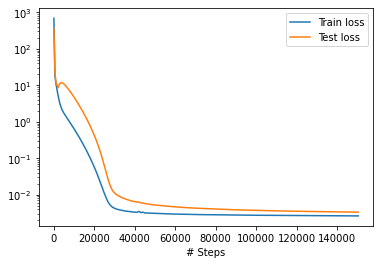

In [ ]:
print(L1.item())
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#### Second launch

In [ ]:
losshistory, train_state, L2 = train(cfg, init_L[1])

1.1983587741851807
Saving loss history to /home/user/MSU/spec_kr/loss.dat ...
Saving training data to /home/user/MSU/spec_kr/train.dat ...
Saving test data to /home/user/MSU/spec_kr/test.dat ...


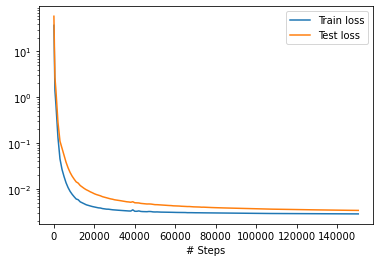

In [ ]:
print(L2.item())
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#### Third launch

In [ ]:
losshistory, train_state, L3 = train(cfg, init_L[2])

1.1966718435287476
Saving loss history to /home/user/MSU/spec_kr/loss.dat ...
Saving training data to /home/user/MSU/spec_kr/train.dat ...
Saving test data to /home/user/MSU/spec_kr/test.dat ...


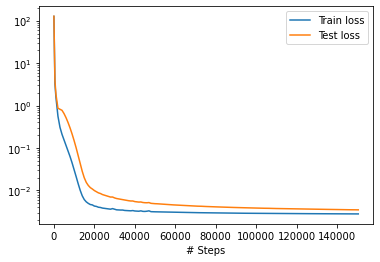

In [ ]:
print(L3.item())
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

### Final lamda

In [ ]:
print(L1.item(), L2.item(), L3.item())

1.1995983123779297 1.1983587741851807 1.1966718435287476


In [ ]:
L = (L1.item() + L2.item() + L3.item()) / 3

In [ ]:
L

1.1982096433639526